In [1]:
# importing relevant packages 

import torch 
from torchvision import models
import pandas as pd
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import glob
import os
import cv2
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import json
from PIL import Image
import random
import albumentations as A
import glob

/home/dell/Desktop/xxxx/Uni/Kirigami_project/Keypoint_detection_notebooks/.Keypoint_detection_notebooks/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
current_dir = os. getcwd()
images_dir = os.path.join(current_dir, 'Kirigami_dataset_2_3_2000')
image_data = pd.read_csv(os.path.join(images_dir, 'Kirigami_dataset_2_3_2000.csv'))
source_images_dir = os.path.join(current_dir, 'Kirigami_dataset_2_3_400')
source_df = pd.read_csv(os.path.join(source_images_dir, 'Kirigami_dataset_2_3_400.csv'))

In [4]:
print(image_data.head(3))

       image_name      p1_x      p1_y      p2_x      p2_y      p3_x      p3_y  \
0  0image0000.jpg  0.117980  0.325008  0.484813  0.121759  0.862980  0.295264   
1  0image0001.jpg  0.141181  0.336857  0.512362  0.144206  0.887927  0.330369   
2  0image0002.jpg  0.074619  0.315151  0.458364  0.153798  0.846891  0.266450   

       p4_x      p4_y      p5_x  ...     p12_x     p12_y     p13_x     p13_y  \
0  0.885033  0.614306  0.524743  ...  0.579912  0.748919  0.587523  0.606982   
1  0.894796  0.650813  0.538433  ...  0.595669  0.743821  0.601462  0.624791   
2  0.864768  0.597400  0.495033  ...  0.551308  0.730463  0.556427  0.592020   

      p14_x     p14_y     p15_x     p15_y     p16_x     p16_y  
0  0.586750  0.469985  0.568052  0.334706  0.541697  0.200831  
1  0.603571  0.489741  0.590300  0.356997  0.569267  0.220827  
2  0.556190  0.452597  0.538366  0.319661  0.516201  0.190396  

[3 rows x 33 columns]


In [5]:
class ImageDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = cv2.imread(img_path)
        label = self.df.iloc[idx, 1:]
        image = self.transform_image(image)
        return image.to(device), torch.tensor(label).to(device)
    
    def __len__(self):
        return self.df.shape[0]
    
    def transform_image(self, img):
        img = cv2.resize(img, (224,224))
        img_tensor = transforms.ToTensor()(img)
        img_mean = img_tensor.mean(dim = (1,2))
        img_std = img_tensor.std(dim = (1,2))
        
        img_normalised = transforms.Normalize(img_mean, img_std)(img_tensor)
        return img_normalised
    
    def load_img(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        img = cv2.imread(img_path)
        return img
    

In [ ]:
def update_data():
    
    files = glob.glob(os.path.join(images_dir, '*'))
    for f in files:
        os.remove(f)
    
    
    header = ['image_name', 'p1_x', 'p1_y', 'p2_x', 'p2_y', 'p3_x', 'p3_y', 'p4_x', 'p4_y', 'p5_x', 'p5_y', 'p6_x', 'p6_y',
              'p7_x', 'p7_y', 'p8_x', 'p8_y', 'p9_x', 'p9_y', 'p10_x', 'p10_y', 'p11_x', 'p11_y', 'p12_x', 'p12_y', 'p13_x',
              'p13_y', 'p14_x', 'p14_y', 'p15_x', 'p15_y', 'p16_x', 'p16_y']
    new_images_df = pd.DataFrame(columns=header)
    
    for j in range(0, 3):
    
        i = 0
        repeat = 0
    
        while i < source_df.shape[0]:
    
            transform = A.Compose([
                A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=1),
                A.RandomBrightnessContrast(brightness_limit=[-0.01, 0.01], contrast_limit=0.3, p=1),
                A.Affine(rotate=random.uniform(-2, 2), p=1),
                A.Affine(translate_percent={'x': random.uniform(-0.05, 0.05), 'y': random.uniform(-0.05, 0.05)}, p=1),
                A.Affine(shear={'x': random.uniform(-2, 2), 'y': random.uniform(-1, 1)}, p=1),
                A.Affine(scale=(0.96, 1.02), p=1)
            ], keypoint_params=A.KeypointParams(format='xy'))
    
            image_to_be_transformed = cv2.imread(os.path.join(source_images_dir, source_df.iloc[i]['image_name']))
    
            x_points = source_df.iloc[i][1:][::2] * image_to_be_transformed.shape[1]
            y_points = source_df.iloc[i][2:][::2] * image_to_be_transformed.shape[0]
            albumentations_keypoints = list(zip(x_points, y_points))
            #         vis_keypoints(image_to_be_transformed, albumentations_keypoints, color=KEYPOINT_COLOR, diameter=15)
    
            transformed = transform(image=image_to_be_transformed, keypoints=albumentations_keypoints)
            transformed_image = transformed['image']
            transformed_keypoints = transformed['keypoints']
    
            #         vis_keypoints(transformed_image, transformed_keypoints, color=KEYPOINT_COLOR, diameter=15)
    
            #         break
    
            if repeat >= 20:
                repeat = 0
                i = i + 1
                continue
    
            if len(transformed_keypoints) != 16:
                print(source_df.iloc[i]['image_name'])
                repeat = repeat + 1
    
                continue
    
            new_image_name = str(j) + source_df.iloc[i]['image_name']
            new_images_df.loc[len(new_images_df)] = new_image_name
    
            flatten_coordinates = np.array(transformed_keypoints).flatten()
            flatten_coordinates[::2] = [x / transformed_image.shape[1] for x in flatten_coordinates[::2]]
            flatten_coordinates[1::2] = [x / transformed_image.shape[0] for x in flatten_coordinates[1::2]]
    
            new_images_df.iloc[len(new_images_df) - 1, 1:33] = flatten_coordinates
    
            transformed_image[..., [0, 2]] = transformed_image[..., [2, 0]]
            img = Image.fromarray(np.uint8(transformed_image))
            img.save(os.path.join(images_dir, new_image_name))
    
            repeat = 0
            i = i + 1
    
    new_images_df.to_csv(os.path.join(images_dir, 'Kirigami_dataset_2_3_2000.csv'), index=False)
    
    print("Finished")
    

In [ ]:
update_data()

In [ ]:
def update_training_set():
    global train_df, test_df, train_dataset, test_dataset, train_dataloader, test_dataloader, image_data
    image_data = pd.read_csv(os.path.join(images_dir, 'Kirigami_dataset_2_3_2000.csv'))
    train_df, test_df = train_test_split(image_data, test_size=0.04)
    train_dataset = ImageDataset(train_df, images_dir)
    test_dataset = ImageDataset(test_df, images_dir)
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

In [ ]:
update_training_set()

In [ ]:
for img, points in train_dataloader:
  print(img.shape)
  print(points.shape)
  break

In [6]:
class VGG_model(nn.Module):
    def __init__(self):
        super(VGG_model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.LeakyReLU(0.1,inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.avgpool = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512,50, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d(output_size=(8,8))
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(3200, 300),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(300, 6),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        

In [7]:
# model = models.vgg16(pretrained=False)
model = VGG_model()

# from torchvision.models import resnet50
# model = resnet50(pretrained=False)

In [8]:
from torch.nn.modules.activation import Sigmoid
from torch.nn.modules.pooling import AdaptiveAvgPool2d
pool_layer = nn.Sequential(
     nn.Conv2d(512,512, kernel_size=3, padding='same'),
     nn.LeakyReLU(0.1,inplace=True),
     nn.MaxPool2d(kernel_size=2, stride=2),
     nn.Conv2d(512,50, kernel_size=3, padding='same'),
     nn.LeakyReLU(0.1,inplace=True),
     nn.MaxPool2d(kernel_size=2, stride=2),
     nn.AdaptiveAvgPool2d(output_size=(8,8))
)

model.avgpool = pool_layer

final_predictor = nn.Sequential(
    nn.Linear(3200, 300),
    nn.LeakyReLU(0.1,inplace=True),
    nn.Dropout(0.3),
    nn.Linear(300, 32),
    nn.Sigmoid()
)

model.classifier = final_predictor

In [9]:
model.load_state_dict(torch.load('./Model_VGG_4_5_6_2000_16300_epoch'))

<All keys matched successfully>

In [ ]:
# from torch.nn.modules.activation import Sigmoid
# from torch.nn.modules.pooling import AdaptiveAvgPool2d
# # pool_layer = nn.Sequential(
# #      nn.Conv2d(512,512, kernel_size=3, padding='same'),
# #      nn.ReLU(inplace=True),
# #      nn.MaxPool2d(kernel_size=2, stride=2),
# #      nn.Conv2d(512,50, kernel_size=3, padding='same'),
# #      nn.ReLU(inplace=True),
# #      nn.MaxPool2d(kernel_size=2, stride=2),
# #      nn.AdaptiveAvgPool2d(output_size=(8,8))
# # )

# # model.avgpool = pool_layer

# final_predictor = nn.Sequential(
#     nn.Linear(2048, 300),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.3),
#     nn.Linear(300, 32),
#     nn.Sigmoid()
# )

# model.fc = final_predictor

In [10]:
model = model.to(device)

In [ ]:
# summary(model, torch.rand(1,3,224,224))
summary(model, (3,224,224))

In [ ]:
# getting the optimizer and loss_function 

def get_essentials():
  loss_fun = nn.L1Loss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
  return loss_fun, optimizer

In [ ]:
# defining batch_train and accuracy functions


def train_batch(data, model, loss_fun, optimizer):
  model.train()
  img, true_points = data
  pred_points = model(img)
  loss_val = loss_fun(pred_points, true_points)
  loss_val.backward()
  optimizer.step()
  optimizer.zero_grad()
  return loss_val.item()

@torch.no_grad()
def val_batch(data, model, loss_fun, optimizer):
  model.eval()
  img, true_points = data
  pred_points = model(img)
  loss_val = loss_fun(pred_points, true_points)
  return loss_val.item()


In [ ]:
epochs = 401
loss_fun, optimizer = get_essentials()

In [ ]:
# training and validation loops 


train_epoch, val_epoch = [], []
for epoch in tqdm(range(epochs)):
  train_batch_losses, val_batch_losses = [], []
  for data in train_dataloader:
    train_batch_loss = train_batch(data, model, loss_fun, optimizer)
    train_batch_losses.append(train_batch_loss)
  for data in test_dataloader:
    val_batch_loss = val_batch(data, model, loss_fun, optimizer)
    val_batch_losses.append(val_batch_loss)
  train_epoch.append(np.mean(train_batch_losses))
  val_epoch.append(np.mean(val_batch_losses))
  
  with open("Model_2_3_2000_output.txt", "a") as f:
    f.write(str([train_batch_loss, val_batch_loss]))
    f.write("\n")
    
  print(train_batch_loss, val_batch_loss)

  if (epoch) % 20 == 0:
    torch.save(model.state_dict(), './Model_2_3_2000_' + str(epoch) + '_epoch')
    update_data()
    update_training_set()
    

In [ ]:
# torch.save(model.state_dict(), './Model_2800_VGG_Leaky_80_epoch')

In [ ]:
plt.plot(range(epochs), train_epoch, label="train_loss")
plt.plot(range(epochs), val_epoch, label="test_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Facial Keypoints model")
plt.show()

# Displaying the results

In [11]:
def transform_image(img):
    img = cv2.resize(img, (224,224))
    img_tensor = transforms.ToTensor()(img)
    img_mean = img_tensor.mean(dim = (1,2))
    img_std = img_tensor.std(dim = (1,2))
        
    img_normalised = transforms.Normalize(img_mean, img_std)(img_tensor)
    return img_normalised

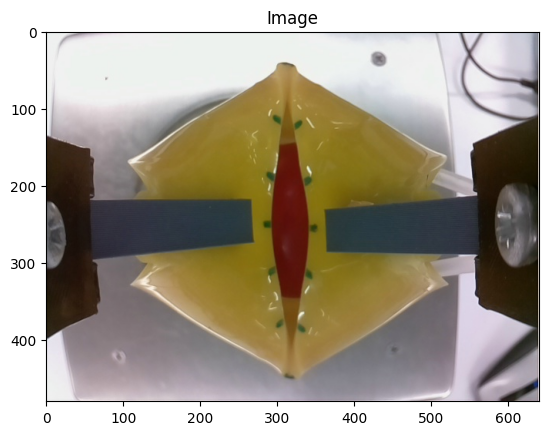

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


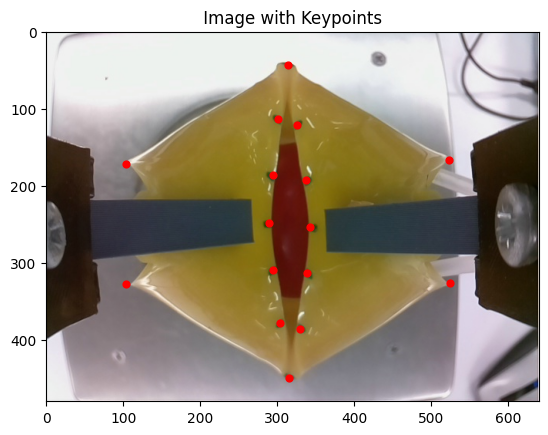

In [16]:
img_path = os.path.join(os.getcwd(), 'Validation_2/Toimage000.jpg')
# img_path = os.path.join(os.getcwd(), 'Grasp_dataset_2/Grasp_dataset_chicken/Chimage029.jpg')
original_img = cv2.imread(img_path)
test_img = transform_image(original_img)
test_img = test_img.to(device)

model.eval()
Facial_key_points = model(test_img[None]).flatten().detach().cpu()

# index = 0

# plt.subplot(121)
plt.title("Image")
original_img = original_img[:,:,::-1]                                                              
plt.imshow(original_img)
plt.show()
# plt.subplot(122)
plt.title(" Image with Keypoints ")
plt.imshow(original_img)

x_points = Facial_key_points.numpy()[0::2]
y_points = Facial_key_points.numpy()[1::2]
plt.scatter(x_points*original_img.shape[1], y_points*original_img.shape[0], s = 24, c=(1,0,0))                       # scaling the keypoints with image dimension
plt.show()